# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    
    c. <a href="https://colab.research.google.com/drive/1LIrkEmbeDYcN9tgWmtmkiYQf_0shGHrC"> Reference_file_1 </a>

    d. <a href="https://colab.research.google.com/drive/1X9fjh4asYry0DPhwjDTAY-e8F14RqoLT"> Reference_file_2 </a>

1. [custom_layers](https://www.youtube.com/watch?v=ucPaDluM4E8&t=63s)
2. [custom_model](https://www.youtube.com/watch?v=OiGvzLEVO9c&feature=emb_logo)

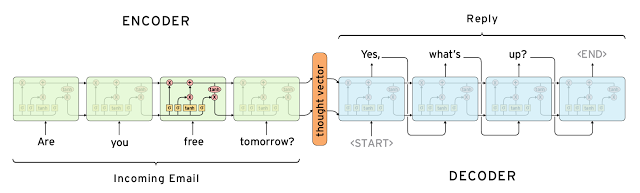

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.activations import tanh

In [ ]:
tf.executing_eagerly()

True

# 1. <font color='orange'>**Load the data**</font>




<font color='pink'>**Downloading italian to english data** </font>

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2022-12-07 10:44:19--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7882203 (7.5M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.52M  3.69MB/s    in 2.0s    

2022-12-07 10:44:21 (3.69 MB/s) - ‘ita-eng.zip’ saved [7882203/7882203]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


<font color='pink'>**Downloading GloVe vector with 300 dimensions** </font>

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-12-07 10:44:22--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-12-07 10:44:22--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07d3c2e411314685a1b2be2716.dl.dropboxusercontent.com/cd/0/inline/ByLGsdcwpHiiTVCAa2MScFxc7ft1ESXyAjdzNWCkqyQ_817ASYrRRlmzfO71jULwKFJEuU3XhTriavPAzA4zxCYnBjn3ehOd-ZiLDowBJrvRAtv54n0HedTsQlMKtW2bRnrjuRi1du1bHDSDaEfgnsAan5FMyzCwCkO1We-B7kh4wg/file# [following]
--2022-12-07 10:44:23--  https://uc07d3c2e411314685a1b2be2716.dl.dropboxusercontent.com/cd/0/inline/ByLGsdcwpHiiTVCAa2MScFxc7ft1ESXyAjdzNWCkqyQ_817ASYrRRlmzfO71jU

In [ ]:
with open ('ita.txt','r+',encoding='utf8') as f :
  eng = []
  ita = []
  for i in f.readlines():
    eng.append(i.split('\t')[0])
    ita.append(i.split('\t')[1])

data = pd.DataFrame(zip(eng,ita),columns=['english','italian'])  
print(data.head(3))
print("**"*30)
print(data.shape)


  english italian
0     Hi.   Ciao!
1     Hi.   Ciao.
2    Run!  Corri!
************************************************************
(358373, 2)


In [ ]:
data.duplicated().any()

False

In [ ]:
data.isnull().values.any()

False

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358373 entries, 0 to 358372
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  358373 non-null  object
 1   italian  358373 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


# 2. <font color='orange'>**Preprocess data**</font>

##<font color='pink'>**Removing special characters** </font>




In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the special characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


##<font color='pink'>**Finding the max length** </font>




In [ ]:
eng_lengths = data['english'].str.split().apply(len)
ita_lengths = data['italian'].str.split().apply(len)

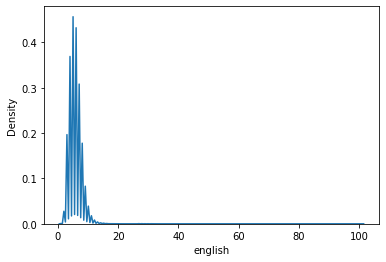

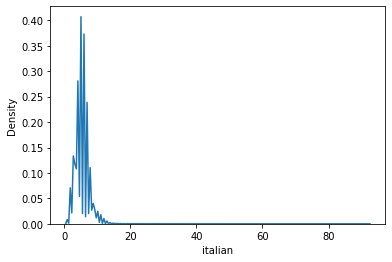

In [ ]:
sns.kdeplot(eng_lengths)
plt.show()
sns.kdeplot(ita_lengths)
plt.show()

<font color='pink'>**for eng sentences :** </font>


In [ ]:
print("0-100 percentile")
for i in range(0,101,10):
    print(f'{i}% -> {np.percentile(eng_lengths, i)}')
print("'^^"*30)

print("90-100 percentile")
for i in range(90,101):
    print(f'{i}% -> {np.percentile(eng_lengths, i)}')

print("'^^"*30)

print("99-100 percentile")
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(f'{i}%-> {np.percentile(eng_lengths, i)}')

0-100 percentile
0% -> 1.0
10% -> 4.0
20% -> 4.0
30% -> 5.0
40% -> 5.0
50% -> 6.0
60% -> 6.0
70% -> 7.0
80% -> 7.0
90% -> 8.0
100% -> 101.0
'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^
90-100 percentile
90% -> 8.0
91% -> 9.0
92% -> 9.0
93% -> 9.0
94% -> 9.0
95% -> 9.0
96% -> 10.0
97% -> 10.0
98% -> 11.0
99% -> 12.0
100% -> 101.0
'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^
99-100 percentile
99.1%-> 12.0
99.2%-> 13.0
99.3%-> 13.0
99.4%-> 13.0
99.5%-> 14.0
99.6%-> 14.0
99.7%-> 15.0
99.8%-> 16.0
99.9%-> 25.0
100%-> 101.0


<font color='pink'>**for italian sentences :** </font>


In [ ]:
print("0-100 percentile")
for i in range(0,101,10):
    print(f'{i}% -> {np.percentile(ita_lengths, i)}')
print("'^^"*30)

print("90-100 percentile")
for i in range(90,101):
    print(f'{i}% -> {np.percentile(ita_lengths, i)}')

print("'^^"*30)

print("99-100 percentile")
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(f'{i}%-> {np.percentile(ita_lengths, i)}')

0-100 percentile
0% -> 1.0
10% -> 3.0
20% -> 4.0
30% -> 4.0
40% -> 5.0
50% -> 5.0
60% -> 6.0
70% -> 6.0
80% -> 7.0
90% -> 8.0
100% -> 92.0
'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^
90-100 percentile
90% -> 8.0
91% -> 8.0
92% -> 8.0
93% -> 9.0
94% -> 9.0
95% -> 9.0
96% -> 9.0
97% -> 10.0
98% -> 11.0
99% -> 12.0
100% -> 92.0
'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^'^^
99-100 percentile
99.1%-> 12.0
99.2%-> 12.0
99.3%-> 13.0
99.4%-> 13.0
99.5%-> 13.0
99.6%-> 14.0
99.7%-> 15.0
99.8%-> 16.0
99.9%-> 22.0
100%-> 92.0


1. From above graphs and percentils calculation we observed that most of the data are below 20 in length.

2. So, considering only those data whose len < 20.


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

print(data.shape)
data.head()


(357866, 4)


,english,italian,italian_len,english_len
0,hi,ciao,1,1
1,hi,ciao,1,1
2,run,corri,1,1
3,run,corra,1,1
4,run,correte,1,1


<font color='pink'>**TEACHER FORCING METHOD :** </font>


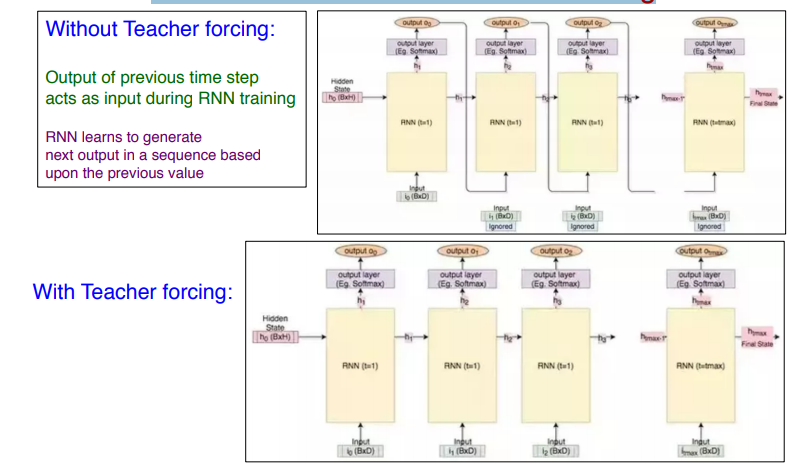

Problems with recursive output-as-input process are ⁉
1. Slow convergence
2. Model instability
3. Poor skill

<font color='yellow'>**TEACHER FORCING** </font> is an approach to improve model skill and stability when training these types of models.


```
Teacher forcing is a strategy for training recurrent neural networks that uses ground truth as input, instead of model output from a prior time step as an input
```
1. Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network.
2. Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with ```<start>``` token at begining of the sentence and other column with ```<end>``` token at the end of the sequence

3. [ref_here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)



 

### Teacher Forcing Example:
<pre>
Let us consider the example data point

italian: erano occupate	
english_inp: &lt;start> they were busy	
                |     |     |    |
english_out:  they   were busy &lt;end>

if you observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out" 

with this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

</pre>

In [ ]:
data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
109973,mio fratello soffre di autismo,<start> my brother has autism,my brother has autism <end>
21838,quello costerà 30,<start> that will be 30,that will be 30 <end>
210808,tom ha rifiutato la mia proposta,<start> tom turned down my proposal,tom turned down my proposal <end>
249348,io sono sicura che tom è molto impressionato,<start> i am sure tom is very impressed,i am sure tom is very impressed <end>
8091,è così carino,<start> he is so cute,he is so cute <end>
265085,non sembra che tom stia affogando,<start> tom does not seem to be drowning,tom does not seem to be drowning <end>
339450,il dottore mi consigliò di non bere troppo,<start> the doctor advised me not to drink too...,the doctor advised me not to drink too much <end>
35657,me lo diede,<start> he gave it to me,he gave it to me <end>
99287,ci siamo incontrati lungo il percorso,<start> we met along the way,we met along the way <end>
228439,perché non lo dimentica e basta,<start> why do not you just forget it,why do not you just forget it <end>


## <font color='orange'>**TRAIN-TEST SPLIT**</font>

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2,random_state=42)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(286292, 3) (71574, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
202468,non penso che sia colpa mia,<start> i do not think it is my fault <end>,i do not think it is my fault <end> <end>
142250,ci si vede fra tre mesi,<start> see you in three months,see you in three months <end>
9500,aiutatemi e basta,<start> just help me,just help me <end>
310927,tom ci ha detto che la stanza era chiusa a chiave,<start> tom told us that the room was locked,tom told us that the room was locked <end>
148333,perché non lascia tom,<start> why do not you leave tom,why do not you leave tom <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
226287,tom è stato fortunato ad ottenere il lavoro,<start> tom was lucky to get the job,tom was lucky to get the job <end>
190020,mia sorella gioca con delle bambole,<start> my sister plays with dolls,my sister plays with dolls <end>
182491,lei riesce a risolvere questo indovinello,<start> can you answer this riddle,can you answer this riddle <end>
115557,a che ora ha mangiato,<start> what time did you eat,what time did you eat <end>
274549,la nostra visita è stata molto piacevole,<start> our visit has been very pleasant,our visit has been very pleasant <end>


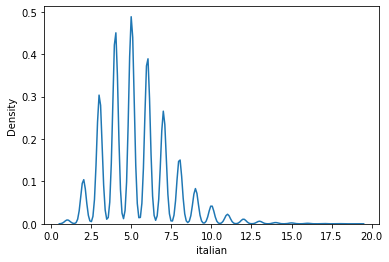

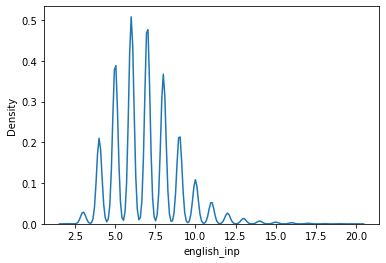

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### <font color='orange'>**DATA TOKENIZING**</font>

1.<font color='pink'>**tokenizing italian data**</font>

In [ ]:
toknizer_ita = Tokenizer()

#Updates internal vocabulary based on a list of texts.
toknizer_ita.fit_on_texts(train['italian'].values) 

vocab_size_ita=len(toknizer_ita.word_index.keys())
print(vocab_size_ita)

26771


2.<font color='pink'>**tokenizing english data**</font>

In [ ]:
toknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

#Updates internal vocabulary based on a list of texts.
toknizer_eng.fit_on_texts(train['english_inp'].values) 

vocab_size_eng=len(toknizer_eng.word_index.keys())
print(vocab_size_eng)

13159


In [ ]:
toknizer_eng.word_index['<start>'], toknizer_eng.word_index['<end>']

(1, 10412)

In [ ]:
toknizer_eng.index_word[1]

'<start>'

In [ ]:
from tqdm.notebook import tqdm

embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tqdm(toknizer_eng.word_index.items(),desc='tokenizing_data'):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

0it [00:00, ?it/s]

tokenizing_data:   0%|          | 0/13159 [00:00<?, ?it/s]

In [ ]:
embedding_matrix.shape

(13160, 100)

## <font color='orange'>**Implement custom encoder decoder**</font>

##<font color='pink'>**Encoder**</font>

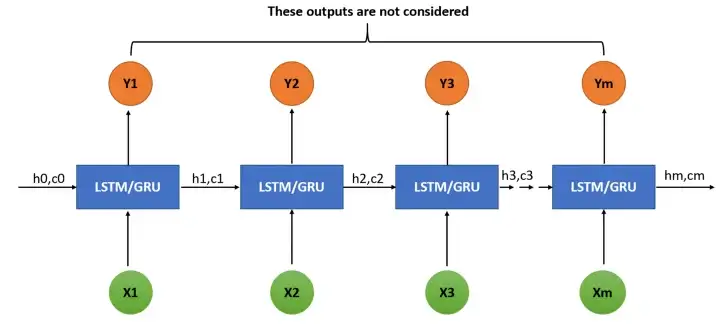

> <font color='lime'>The **ENCODER LSTM** is used to process the entire input sentence and encode it into a context vector, which is the last hidden state of the LSTM/RNN. This is expected to be a good summary of the input sentence. All the intermediate states of the encoder are ignored, and the final state id supposed to be the initial hidden state of the decoder </font>

In [ ]:
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      #to inherit all the properties of parent class[here:layer class]
      super().__init__()     

      self.inp_vocab_size = inp_vocab_size
      self.embedding_size = embedding_size
      self.lstm_size = lstm_size
      self.input_length = input_length
      self.encoder_output = 0
      self.encoder_state_h = 0 #encoder hidden state
      self.encoder_state_c = 0 #encoder cell state
    
    def build(self,input_shape):
      #Initialize Embedding layer
      #Intialize Encoder LSTM layer
      self.embedding_layer = Embedding(input_dim =self.inp_vocab_size,
                                  output_dim = self.embedding_size,
                                  input_length = self.input_length,
                                  mask_zero =  True,
                                  name ="encoder_embedding_layer"
                                  )
      
      self.lstm_layer = LSTM(units=self.lstm_size,
                        return_state = True,
                        return_sequences = True,
                        name ='encoder_lstm_layer')

   
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''

      self.encoder_initial_state_h = tf.zeros(shape=[batch_size,self.lstm_size])
      self.encoder_initial_state_c = tf.zeros(shape=[batch_size,self.lstm_size])

      return [self.encoder_initial_state_h, self.encoder_initial_state_c]

    def call(self,input_sequence,states,training=True):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        # print("Encoder input shape =", input_sequence.shape)
        input_embedding = self.embedding_layer(input_sequence)

        # print("After embedding input shape = ", input_embedding.shape)
        
        self.encoder_output, self.encoder_state_h, self.encoder_state_c = self.lstm_layer(input_embedding,states)

        return self.encoder_output, self.encoder_state_h, self.encoder_state_c

    def get_states(self):
        return [self.encoder_state_h,self.encoder_state_c]


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


##<font color='pink'>**DECODER**</font>

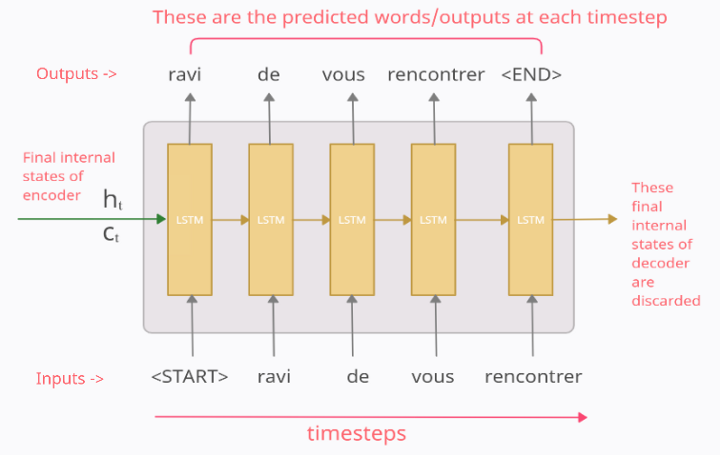

<font color='lime'>The decoder LSTM or RNN units takes the summary (context vector) of the encoder and produce the words in a sentence one after another</font>

In [ ]:
class Decoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
      #to inherit all the properties of parent class[here:layer class]
      super().__init__() 

      self.out_vocab_size = out_vocab_size
      self.embedding_size = embedding_size
      self.lstm_size = lstm_size
      self.input_length = input_length

    
      #Initialize Embedding layer
      #Intialize Encoder LSTM layer
      self.embedding_layer = Embedding(input_dim =self.out_vocab_size,
                                  output_dim = self.embedding_size,
                                  input_length = self.input_length,
                                  mask_zero =  True,
                                  trainable=False,
                                  name ="decoder_embedding_layer"
                                  )
      
      self.decoder_lstm = LSTM(units=self.lstm_size,
                        return_state = True,
                        return_sequences = True,
                        name ='decoder_lstm_layer')
        


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        #print("Decoder input sequences shape = ", input_sequence.shape)
        input_embedding = self.embedding_layer(input_sequence)

        #print("After embedding input shape= ", input_embedding.shape)

        decoder_output, decoder_final_state_h, decoder_final_state_c = self.decoder_lstm(input_embedding,initial_states)

        return decoder_output,decoder_final_state_h,decoder_final_state_c



<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


##<font color='pink'>**CREATING DATA PIPELINE**</font>

In [ ]:
class Dataset((tf.keras.utils.Sequence)):
    def __init__(self, data, toknizer_ita, toknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.toknizer_eng = toknizer_eng
        self.toknizer_ita = toknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.toknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.toknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.toknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit requires this function
        return len(self.encoder_inps)

  

In [ ]:
train_dataset = Dataset(data=train, toknizer_ita=toknizer_ita, toknizer_eng=toknizer_eng, max_len=20)
test_dataset  = Dataset(data=validation, toknizer_ita=toknizer_ita, toknizer_eng=toknizer_eng, max_len=20)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:

train_dataloader = Dataloder(dataset=train_dataset, batch_size=1024)
test_dataloader = Dataloder(dataset=test_dataset, batch_size=1024)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)
(1024, 20) (1024, 20) (1024, 20)


##<font color='pink'>**ENCODER--DECODER MODEL**</font>

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, encoder_inputs_length,decoder_inputs_length,input_vocab_size,output_vocab_size,batch_size):
      super().__init__()


        #Create encoder object
      self.encoder = Encoder(inp_vocab_size=input_vocab_size+1, 
                             embedding_size=50, 
                             input_length=encoder_inputs_length, 
                             lstm_size=256)
        
        #Create decoder object
      self.decoder = Decoder(out_vocab_size=output_vocab_size+1,
                             embedding_size=100, 
                             input_length=decoder_inputs_length, 
                             lstm_size=256)
        
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
      self.dense   = TimeDistributed ( Dense(units = output_vocab_size, activation='softmax') )

      self.batch_size = batch_size
          
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
      
        input,output = data[0], data[1]
        states = self.encoder.initialize_states(self.batch_size)

        # print("Encoder input shape = ",input.shape)
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(data[0],states)
        
        # print('encoder output shape = ',encoder_output.shape)
        # print('encoder hidden state shape = ',encoder_final_state_h.shape)
        # print('encoder cell state shape = ',encoder_final_state_c.shape)
       # print("^^"*30)
        
       # print("Decoder input shape = ",output.shape)
        initial_states = [encoder_final_state_h,encoder_final_state_c]
        decoder_output ,decoder_final_state_h, decoder_final_state_c = self.decoder(data[1], initial_states)
       # print('decoder output shape = ',decoder_output.shape)
       # print('decoder hidden state shape = ',decoder_final_state_h.shape)
        # print('decoder cell state shape = ',decoder_final_state_c.shape)

        output = self.dense(decoder_output)
        # print(output.shape)

        return output
    
        
        

##<font color='pink'>**MODEL TRAINING**</font>

In [ ]:
#Create an object of encoder_decoder Model class, 
model =  Encoder_decoder(encoder_inputs_length=20,
                         decoder_inputs_length=20,
                         input_vocab_size = vocab_size_ita,
                         output_vocab_size = vocab_size_eng,
                         batch_size = 1024
                         )

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024


model.fit(train_dataloader, 
          steps_per_epoch=train_steps, 
          epochs=50, 
          validation_data=train_dataloader, 
          validation_steps=valid_steps)


model.summary()

Epoch 1/50
279/279 [==============================] - 113s 383ms/step - loss: 1.8576 - val_loss: 1.6641
Epoch 2/50
279/279 [==============================] - 106s 381ms/step - loss: 1.6125 - val_loss: 1.5611
Epoch 3/50
279/279 [==============================] - 106s 381ms/step - loss: 1.5032 - val_loss: 1.4334
Epoch 4/50
279/279 [==============================] - 106s 380ms/step - loss: 1.3786 - val_loss: 1.3137
Epoch 5/50
279/279 [==============================] - 107s 382ms/step - loss: 1.2529 - val_loss: 1.1766
Epoch 6/50
279/279 [==============================] - 107s 382ms/step - loss: 1.1191 - val_loss: 1.0534
Epoch 7/50
279/279 [==============================] - 106s 380ms/step - loss: 1.0080 - val_loss: 0.9513
Epoch 8/50
279/279 [==============================] - 107s 382ms/step - loss: 0.9138 - val_loss: 0.8658
Epoch 9/50
279/279 [==============================] - 106s 380ms/step - loss: 0.8315 - val_loss: 0.7855
Epoch 10/50
279/279 [==============================] - 106s 380m

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, 
                                  using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  #print(input_sentence)
  #print("Tokenizing input sentence...")

  tokens = toknizer_ita.texts_to_sequences([input_sentence])
  #print(tokens)
  padded_tokens = pad_sequences(tokens,maxlen =20, dtype='int32', padding='post')
  #print(padded_tokens)
  #tokens = (np.array([tkn[0] for tkn in tokens if tkn!=[]])).reshape(1,-1)

  #print("done")
  #print(tokens)
  #print("###"*20)

  # passing tokenized input to encoder(which is the layer[0] in our model)
 # encoder_initial_state_h = tf.zeros(shape=[1,256])
  #encoder_initial_state_c = tf.zeros(shape=[1,256])
  encoder_output, encoder_hidden_state, encoder_cell_state = model.layers[0](padded_tokens, None)

  
  predicted_output = []

  decoder_input = (np.array(toknizer_eng.word_index['<start>'])).reshape(1,-1)
  states = [encoder_hidden_state,encoder_cell_state]

  #print("Decoding the output...")

  while decoder_input != toknizer_eng.word_index['<end>']:
    decoder_ouput, decoder_hidden_state, decoder_cell_state = model.layers[1](decoder_input,states)
    dense_output = model.layers[2](decoder_ouput)

    #updating decoder states
    states = [decoder_hidden_state,decoder_cell_state]

    final_output = np.argmax(dense_output)
    predicted_output.append(final_output)
    #print(predicted_output)
    decoder_input = final_output.reshape(1,-1)
  
  eng_sentence = []
  for idx in predicted_output:
    eng_sentence.append(toknizer_eng.index_word[idx])
  return " ".join(eng_sentence)
    

In [ ]:
validation.iloc[99]

italian        io ho chiesto a tom di pulire la sua camera
english_inp          <start> i asked tom to clean his room
english_out            i asked tom to clean his room <end>
Name: 232230, dtype: object

In [ ]:
predict(validation['italian'].iloc[99])

io ho chiesto a tom di pulire la sua camera
[[9, 16, 216, 5, 1, 4, 1115, 7, 61, 404]]
[[   9   16  216    5    1    4 1115    7   61  404    0    0    0    0
     0    0    0    0    0    0]]


'i asked tom to clean his room <end>'

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

import nltk.translate.bleu_score as bleu
random_samples = validation.sample(1000)
bleu_scores = []
for idx in random_samples.index:
  reference = random_samples['english_out'][idx].split() # the original
  translation = predict(random_samples['italian'][idx]).split() # trasilated using model
  bleu_scores.append(bleu.sentence_bleu([reference], translation,smoothing_function=bleu.SmoothingFunction().method1))

print("Average BLEU score for 1000 sentences = ",np.average(np.array(bleu_scores)))

Average BLEU score for 1000 sentences =  0.6149099666895915




```
 Drawback of Encoder-Decoder model :
```
1. The main drawback of this approach is evident. If the encoder makes a bad summary, the translation will also be bad. And indeed it has been observed that **the encoder creates a bad summary when it tries to understand longer sentences. It is called the <font color='yellow'>long-range dependency problem </font> of RNN/LSTMs.**
> RNNs cannot remember longer sentences and sequences due to the <font color='yellow'>vanishing/exploding gradient problem.</font>

2. Another problem is that there is no way to give more importance to some of the input words compared to others while translating the sentence. 

> So is there any way we can keep all the relevant information in the input sentences intact while creating the context vector?


####################################################################################################################################################################################################

## <font color ='yellow'> Task -2: Including Attention mechanism <font>

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='orange'>**Implement custom encoder decoder and attention layers**</font>

##<font color='orange'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      self.inp_vocab_size = inp_vocab_size
      self.embedding_size = embedding_size
      self.lstm_size = lstm_size
      self.input_length = input_length
      self.encoder_output = 0
      self.encoder_hidden_state = 0
      self.encoder_cell_state = 0
        
      self.embedding_layer = Embedding(input_dim=self.inp_vocab_size, 
                                         output_dim=self.embedding_size
                                       ,input_length=self.input_length, 
                                       mask_zero=True, 
                                       name="embedding_layer_encoder")
        
      self.lstm = CuDNNLSTM(self.lstm_size, 
                       return_state=True, 
                       return_sequences=True, 
                       name="Encoder_LSTM")

    def call(self,input_sequence,states,training=True):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
     # print("input_sequence shape = ",input_sequence.shape)
      input_embedding = self.embedding_layer(input_sequence)

     # print("After embedding = ",input_embedding.shape)

      self.encoder_output, self.encoder_hidden_state, self.encoder_cell_state =  self.lstm(input_embedding, states)

      #print("Encoder output shape =",self.encoder_output.shape)
     # print("Encoder hidden state shape =",self.encoder_hidden_state.shape)
      #print("Encoder cell state shape =",self.encoder_cell_state.shape)


      return self.encoder_output, self.encoder_hidden_state, self.encoder_cell_state

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.encoder_initial_state_h = tf.zeros(shape=[batch_size,self.lstm_size])
      self.encoder_initial_state_c = tf.zeros(shape=[batch_size,self.lstm_size])

      return [self.encoder_initial_state_h, self.encoder_initial_state_c]

    def get_states(self):
      return [self.encoder_hidden_state,self.encoder_cell_state]

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


##<font color='pink'>**ATTENTION**</font>

> Bahdanau et al (2015) came up with a simple but elegant idea where they suggested that not only can all the input words be taken into account in the context vector, but relative importance should also be given to each one of them.

> So, whenever the proposed model generates a sentence, it searches for a set of positions in the encoder hidden states where the most relevant information is available. This idea is called ‘Attention’.

1. The most important distinguishing feature of <font color='violet'>**Bahdanu attention mechanism**</font> from the basic encoder-decoder is that it does not attempt to encode a whole input sentence into a single fixed-length vector. Instead, it encodes the input sentence into a sequence of vectors and chooses a subset of these vectors adaptively while decoding the translation.

2. The role of the decoder is to produce the target words by focusing on the most relevant information contained in the source sentence. For this purpose, it makes use of an attention mechanism.

```
Each time the proposed model generates a word in a translation, it (soft-)searches for a set of positions in a source sentence where the most relevant information is concentrated. The model then predicts a target word based on the context vectors associated with these source positions and all the previous generated target words.```

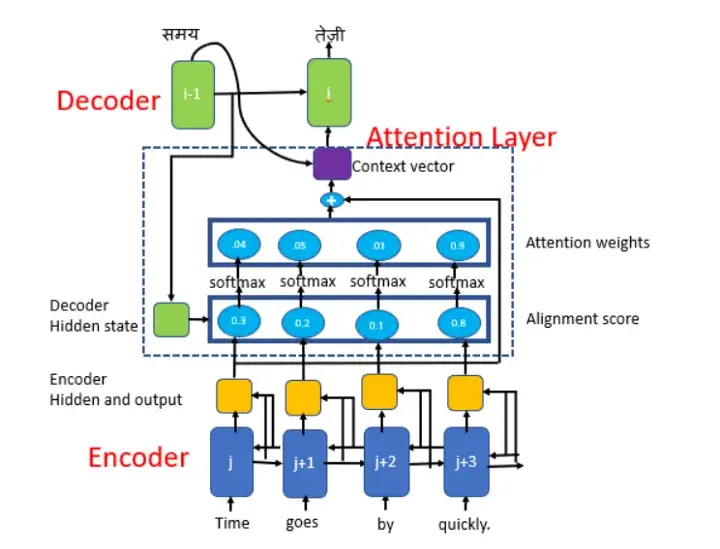

In [ ]:
from tensorflow.python.ops.session_ops import encode_resource_handle
from tensorflow.python.ops.parsing_ops import decode_raw_eager_fallback


class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    # Please go through the reference notebook and research paper to complete the scoring functions

    #dot product between the decoder and encoder hidden states.
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass

    elif scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.w = Dense(self.att_units)
      pass

    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.w1 = tf.keras.layers.Dense(att_units)
      self.w2 = tf.keras.layers.Dense(att_units)
      self.v= tf.keras.layers.Dense(1)      
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    if self.scoring_function == 'dot':
      decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
      score = tf.keras.layers.dot([encoder_output, decoder_hidden_state],[2, 1]) 
      pass
    
    elif self.scoring_function == 'general':
        # Implement General score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state,2)
        score = tf.matmul(self.w(encoder_output),decoder_hidden_state)
        pass

    elif self.scoring_function == 'concat': 
      # Implement General score function here
       decoder_hidden_state = tf.expand_dims(decoder_hidden_state,1)
       score = self.v(tf.nn.tanh(self.w1(decoder_hidden_state) + self.w2(encoder_output)))
       pass
    
    weights = tf.nn.softmax(score,axis=1)
    context_vector = weights*encoder_output
    context_vector = tf.reduce_sum(context_vector,axis=1)
    return context_vector, weights    

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    super().__init__()

    self.score_fun = score_fun
    self.att_units = att_units

      # Initialize decoder embedding layer, LSTM and any other objects needed
    self.embedding_layer = Embedding(input_dim =tar_vocab_size,
                                  output_dim = embedding_dim,
                                  input_length = input_length,
                                  mask_zero =  True,
                                  trainable=False,
                                  name ="decoder_embedding_layer"
                                  )
      
    self.decoder_lstm = CuDNNLSTM(units= dec_units,
                        return_state = True,
                        return_sequences = True,
                        name ='decoder_lstm_layer')
     
    self.attention = Attention(score_fun,att_units)

    self.w1 = tf.keras.layers.Dense(att_units)
    self.w2 = tf.keras.layers.Dense(att_units)

    self.dense = Dense(units = tar_vocab_size)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    input_embedding = self.embedding_layer(input_to_decoder)
    #print("input_embedding shape = ",input_embedding.shape)

    context_vector, attention_weights = self.attention(state_h,encoder_output)
    #print("context_vec shape = ", context_vector.shape)
    #print("attention_weights shape = ", attention_weights.shape)


    state_h = tf.expand_dims(state_h,1)
    #print("state_h = ", state_h.shape)
    #print("encoder output shape = ",encoder_output.shape)
    concatenation = self.w1(state_h) + self.w2(encoder_output)
    #print("conc shape =",concatenation.shape)

    decoder_output, decoder_hidden_state, decoder_cell_state = self.decoder_lstm(concatenation)
    #print("decoder_output shape = ",decoder_output.shape)
    #print("decoder_hidden_state shape = ",decoder_hidden_state.shape)
    #print("decoder_cell_state shape = ",decoder_cell_state.shape)


    decoder_output = tf.keras.layers.Flatten()(decoder_output)
    output = self.dense(decoder_output)
    #print("output shape = ",output.shape)
    #print(output.shape) 

    return output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector



<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super(Decoder,self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length =input_length
      self.dec_units =dec_units
      self.score_fun = score_fun
      self.att_units = att_units

      self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, 
                                             input_length, dec_units ,
                                             score_fun ,att_units)
    @tf.function   
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

         output_tensor = tf.TensorArray(dtype = tf.float32, 
                        size= 20,
                        name="output_store")

         for timestep in range(20) :
           output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector =  self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                                                                      encoder_output,
                                                                                                                      decoder_hidden_state,
                                                                                                                      decoder_cell_state)    
           
           output_tensor = output_tensor.write(timestep,output)

         output_tensor = tf.transpose(output_tensor.stack(), [1,0,2])

         return output_tensor   
           
        
    

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length,decoder_inputs_length,input_vocab_size,output_vocab_size,batch_size,score_fun,att_units):
    super().__init__()
    #Intialize objects from encoder decoder
    self.encoder = Encoder(inp_vocab_size=input_vocab_size+1, 
                             embedding_size=50, 
                             input_length=encoder_inputs_length, 
                             lstm_size=256)
    
    
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1,
                             embedding_dim=100, 
                             input_length=decoder_inputs_length, 
                             dec_units=256,
                             score_fun =score_fun,
                             att_units = att_units )
    self.batch_size = batch_size
    

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
        input,output = data[0], data[1]
        print("input shape = ", input.shape)
        print("output shape = ", output.shape
              )
        states = self.encoder.initialize_states(self.batch_size)

        encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(data[0],states)
        
        decoder_output = self.decoder(data[1], encoder_output,encoder_final_state_h, encoder_final_state_c)
        return decoder_output





<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    print(real.shape)
    print(pred.shape)
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#<font color='orange'>**Training**</font>

##<font color='yellow'>Implement dot function here</font>

---



In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [ ]:
#Create an object of encoder_decoder Model class, 
attn_model =  encoder_decoder(encoder_inputs_length=20,
                         decoder_inputs_length=20,
                         input_vocab_size = vocab_size_ita,
                         output_vocab_size = vocab_size_eng,
                         batch_size = 1024,
                         score_fun = 'dot',
                         att_units = 16
                         )

In [ ]:
optimizer = tf.keras.optimizers.Adam()

attn_model.compile(optimizer=optimizer, loss= loss_function)

train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024


attn_model.fit(train_dataloader, 
          steps_per_epoch=train_steps, 
          epochs=25, 
          validation_data=train_dataloader, 
          validation_steps=valid_steps)


attn_model.summary()

input shape =  (1024, 20)
output shape =  (1024, 20)
Epoch 1/25
input shape =  (None, None)
output shape =  (None, None)
(None, None)
(1024, 20, 13160)
input shape =  (None, None)
output shape =  (None, None)
(None, None)
(1024, 20, 13160)
279/279 [==============================] - ETA: 0s - loss: 1.6890input shape =  (None, None)
output shape =  (None, None)
(None, None)
(1024, 20, 13160)
279/279 [==============================] - 840s 3s/step - loss: 1.6890 - val_loss: 1.4572
Epoch 2/25
279/279 [==============================] - 826s 3s/step - loss: 1.3272 - val_loss: 1.1939
Epoch 3/25
279/279 [==============================] - 830s 3s/step - loss: 1.1042 - val_loss: 0.9782
Epoch 4/25
279/279 [==============================] - 841s 3s/step - loss: 0.9110 - val_loss: 0.7913
Epoch 5/25
279/279 [==============================] - 833s 3s/step - loss: 0.7425 - val_loss: 0.6328
Epoch 6/25
279/279 [==============================] - 834s 3s/step - loss: 0.6142 - val_loss: 0.5341
Epoch 7/25
2

#<font color='orange'>**Inference**</font>

##<font color='orange'>**Plot attention weights**</font>

In [ ]:
def plot_attention(params):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate


##<font color='orange'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence):

   '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  #print(input_sentence)
  #print("Tokenizing input sentence...")

  tokens = toknizer_ita.texts_to_sequences([input_sentence])
  #print(tokens)
  padded_tokens = pad_sequences(tokens,maxlen =20, dtype='int32', padding='post')
  #print(padded_tokens)
  #tokens = (np.array([tkn[0] for tkn in tokens if tkn!=[]])).reshape(1,-1)

  #print("done")
  #print(tokens)
  #print("###"*20)

  # passing tokenized input to encoder(which is the layer[0] in our model)
 # encoder_initial_state_h = tf.zeros(shape=[1,256])
  #encoder_initial_state_c = tf.zeros(shape=[1,256])
  encoder_output, encoder_hidden_state, encoder_cell_state = model.layers[0](padded_tokens, None)

  
  predicted_output = []

  decoder_input = (np.array(toknizer_eng.word_index['<start>'])).reshape(1,-1)
  states = [encoder_hidden_state,encoder_cell_state]

  #print("Decoding the output...")

  while decoder_input != toknizer_eng.word_index['<end>']:

    output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = model.layers[1](decoder_input, 
                                                                                                          encoder_output, 
                                                                                                          encoder_hidden_state, 
                                                                                                          encoder_cell_state)

    #updating decoder states
    states = [decoder_hidden_state,decoder_cell_state]

    final_output = np.argmax(attention_weights)
    predicted_output.append(final_output)
    #print(predicted_output)
    decoder_input = final_output.reshape(1,-1)
  
  eng_sentence = []
  for idx in predicted_output:
    eng_sentence.append(toknizer_eng.index_word[idx])
  return " ".join(eng_sentence)
  

In [ ]:
def predict(input_sentence):

 

##<font color='orange'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

<font color='orange'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

##<font color='orange'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function